In [1]:
import os
import sys
from data.usc.folds import get_fold
from data.usc.features import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline
import pylab

In [2]:
def get_data(feature_dir, fold_idx_list):
    X = []
    y = []
    file_idxs = []
    filenames = []

    for fold_idx in fold_idx_list:
        fold_data = get_fold(feature_dir, fold_idx, augment=True)

        X.append(fold_data['features'])
        y.append(fold_data['labels'])
        idxs = fold_data['file_idxs']

        if len(file_idxs) > 0:
            idxs = idxs + file_idxs[-1][-1, -1]
        file_idxs.append(idxs)

        filenames += fold_data['filenames']

    X = np.vstack(X)
    y = np.concatenate(y)
    file_idxs = np.vstack(file_idxs)

    return {'features': X, 'labels': y, 'file_idxs': file_idxs,
            'filenames': filenames}

In [3]:
def preprocess_data(viz_data, feature_mode='framewise', non_overlap=False,
                    non_overlap_chunk_size=10, use_min_max=False):
    
    # NOTE: This function mutates data so there aren't extra copies

    # Remove overlapping frames if no overlap
    if non_overlap:
        remove_data_overlap(viz_data, chunk_size=non_overlap_chunk_size)

    # Apply min max scaling to data
    min_max_scaler = MinMaxScaler()
    if use_min_max:
        train_data['features'] = min_max_scaler.fit_transform(viz_data['features'])

    if feature_mode == 'framewise':
        # Expand the labels to apply to each frame
        expand_framewise_labels(viz_data)
        
    elif feature_mode == 'stats':
        # Summarize frames in each file using summary statistics
        framewise_to_stats(viz_data)
        
    else:
        raise ValueError('Invalid feature mode: {}'.format(feature_mode))

    # Standardize features
    stdizer = StandardScaler()
    viz_data['features'] = stdizer.fit_transform(viz_data['features'])


    # Shuffle training data
    num_data_examples = len(viz_data['labels'])
    shuffle_idxs = np.random.permutation(num_data_examples)
    reverse_shuffle_idxs = np.argsort(shuffle_idxs)
    viz_data['features'] = viz_data['features'][shuffle_idxs]
    viz_data['labels'] = viz_data['labels'][shuffle_idxs]
    viz_data['file_idxs'] = [reverse_shuffle_idxs[slice(*pair)] \
                            for pair in viz_data['file_idxs']]

    return min_max_scaler, stdizer

In [15]:
def show_viz(trans_data, labels, title):
    cm = plt.cm.get_cmap('tab20c')
    cm_lst = [cm.colors[i] for i in range(num_classes)]
    
    #plt.subplot(3, 2, idx)
    plt.figure(figsize=(12,8))
    plt.title(title)
    x = []
    y = []
    for value in trans_data:
        x.append(value[0])
        y.append(value[1])
   
    for i in range(len(trans_data)):
        plt.scatter(x[i],y[i], c=cm_lst[labels[i]])
        plt.annotate(labels[i], alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                     textcoords='offset points', ha='right', va='bottom', size=7)
    plt.show()

In [8]:
num_classes=10
features_dir='/scratch/sk7898/embeddings/features/us8k/l3/reduced_input/original_48000_256_252_2048'
feature_mode='framewise'
non_overlap=False
non_overlap_chunk_size=10
use_min_max=False
batch_size=1024
fold_idx_list = [0]

#Loading data for dimensionality reduction
viz_data = get_data(features_dir, fold_idx_list)

#Preprocessing data
min_max_scaler, stdizer = preprocess_data(viz_data, feature_mode=feature_mode,\
                                          non_overlap=non_overlap,\
                                          non_overlap_chunk_size=non_overlap_chunk_size,\
                                          use_min_max=use_min_max)

X = viz_data['features']
y = viz_data['labels']

In [9]:
data = X[:batch_size,:]
labels = y[:batch_size]

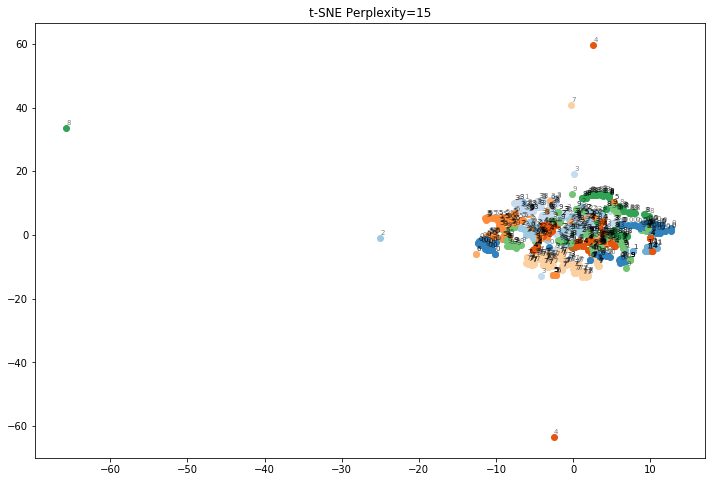

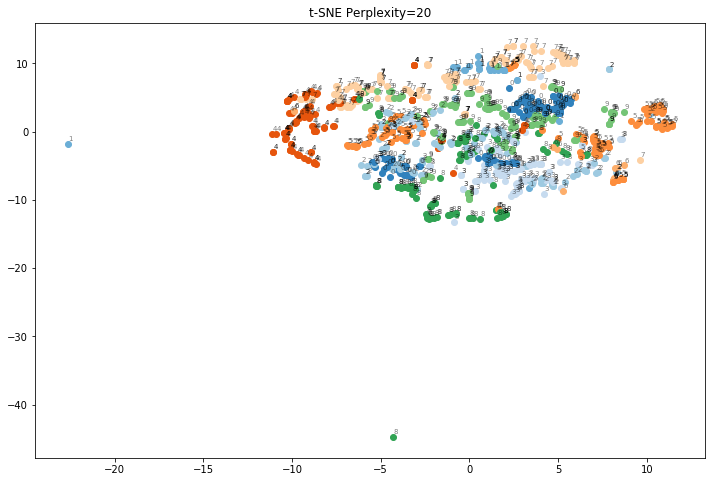

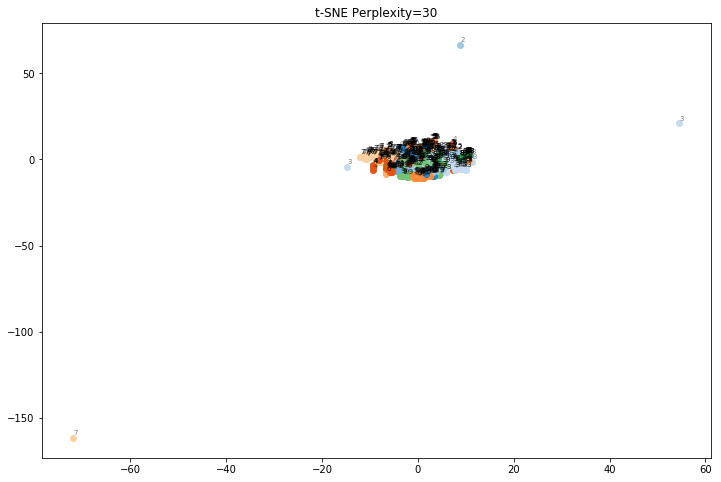

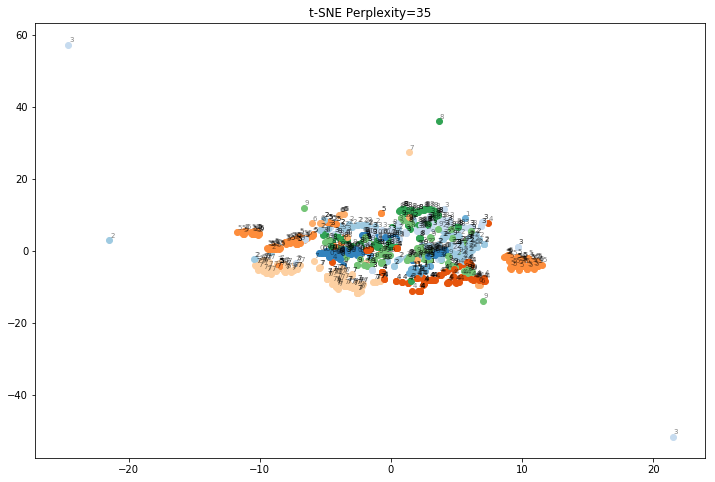

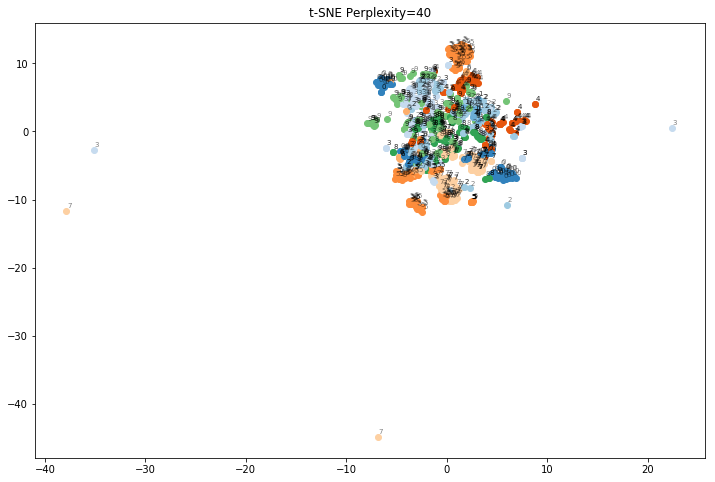

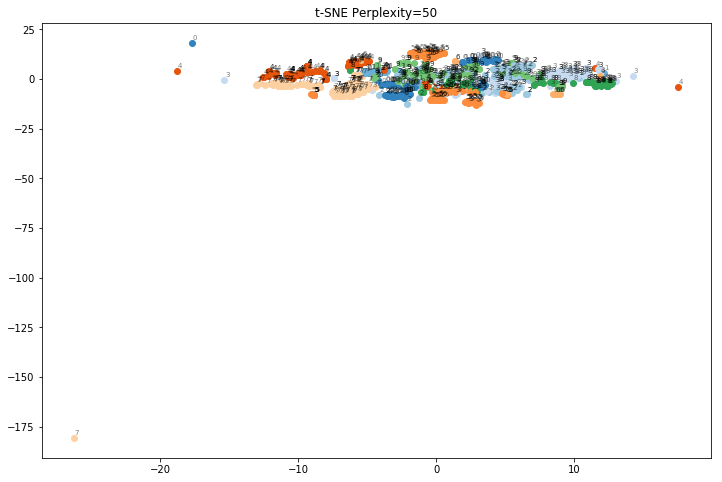

In [19]:
from sklearn.manifold import TSNE
perplexities = [15, 20, 30, 35, 40, 50]

#Barnes-Hut Implementation
for i in range(len(perplexities)):
    trans_data = TSNE(perplexity=perplexities[i], n_components=3, n_iter=300).fit_transform(data)
    plt_title = 't-SNE Perplexity='+str(perplexities[i])
    show_viz(trans_data, labels, plt_title)

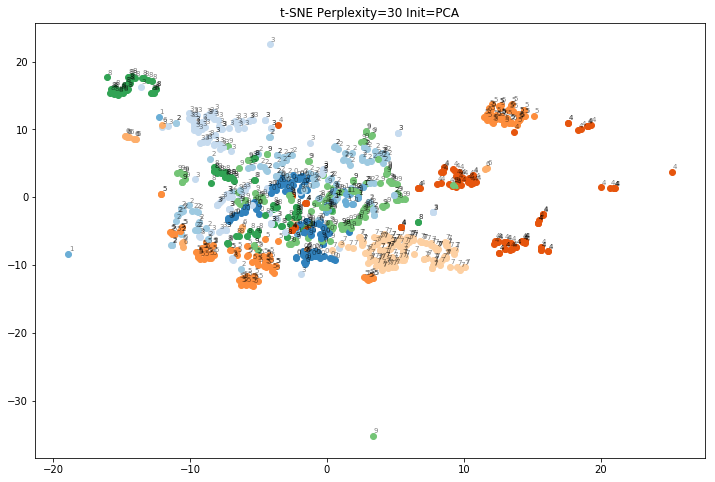

In [27]:
tsne_data = TSNE(perplexity=30, n_components=3, init='pca', n_iter=300).fit_transform(data)
plt_title = 't-SNE Perplexity=30 Init=PCA'
show_viz(tsne_data, labels, plt_title)

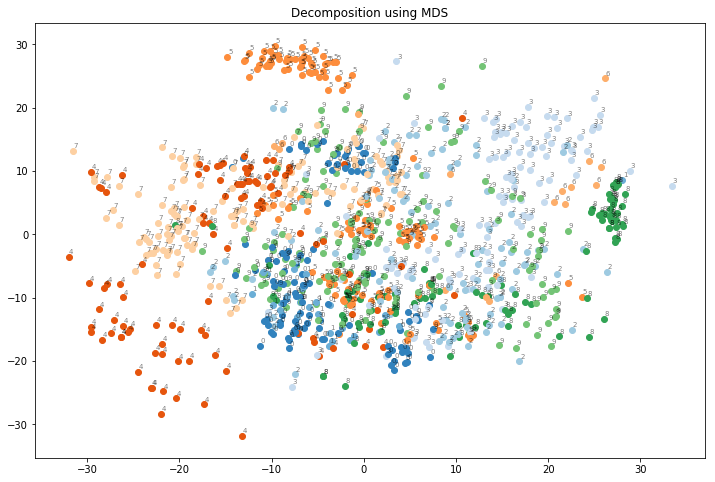

In [20]:
#Very slow
from sklearn.manifold import MDS
embedding = MDS(n_components=3)
mds_data = embedding.fit_transform(data)
show_viz(mds_data, labels, 'Decomposition using MDS')

/home/sk7898/miniconda3/envs/l3embedding-new-cpu/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


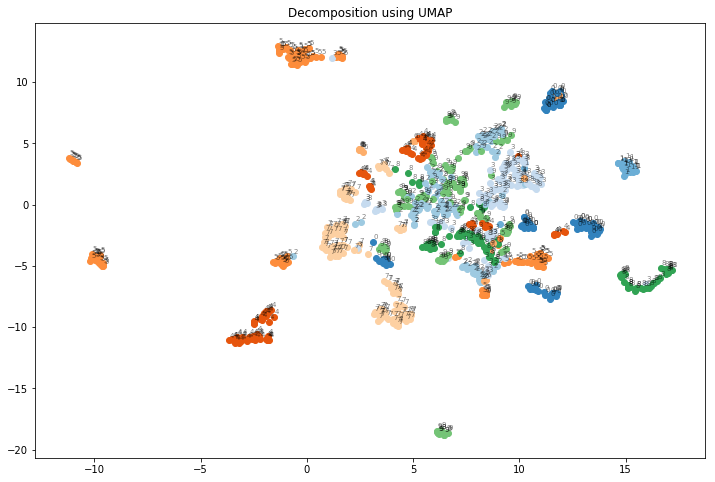

In [29]:
import umap
umap_data = umap.umap_.UMAP(n_neighbors=10, min_dist=0.5, n_components=2).fit_transform(data)
show_viz(umap_data, labels, 'Decomposition using UMAP')